<h1>Case study</h1>

We will run the case study called "mixing". This case study has five competing models (each with one model parameter) and three design variables. The design variables are the residence time $x_1 \in [1,\, 100]$, initial concentration $x_2 \in [0.01,\,1]$, and reactor type $x_3 \in \lbrace 0,\, 1 \rbrace$. The last design variable determines whether we run an experiment in a continuous stirred-tank reactor (CSTR; $x_3=0$) or a plugflow reactor (PFR; $x_3=1$).

In [1]:
from GPdoemd.case_studies.analytic import mixing

When we call the case study's $\texttt{get(i)}$ function, we can set the data-generating model $\texttt{i} \in \lbrace 0,\dots,4 \rbrace$. The difficulty depends on the choice of data-generating model: $\texttt{i} = 2$ has medium difficulty, whereas $\texttt{i}=3,4$ is more difficult.

In [2]:
measurement, models = mixing.get(i=2)

Bounds on the design variables

In [3]:
x_bounds = measurement.x_bounds

The data-generating/measurement model has a pre-defined measurement noise variance

In [4]:
measvar = measurement.measvar

<h1>Initial data</h1>

We have two initial observations.

In [5]:
import numpy as np

X = np.array([[ 20., 0.50, 0 ],
              [ 20., 0.75, 0 ]])
Y = np.array([[ 0.766 ],
              [ 0.845 ]])

We initialise the custom interface for plotting the results in this demo

In [6]:
from demo_utils.case_study_graphics import Graphics
graphics = Graphics(X, Y, measvar)

<h1>Initialise GP surrogate models</h1>

We initialise the GP surrogate models by passing dictionaries to the GPModel class.

In [7]:
from GPdoemd.models import VanillaGPModel

Ms = []
for m in models:
    d = {
        'name':             m.name,       # Model name
        'call':             m,            # Function handle for evaluating the model
        'dim_x':            3,            # Number of design variables
        'dim_p':            1,            # Number of model parameters
        'p_bounds':         m.p_bounds,   # Bounds on the model parameters
        'num_outputs':      1,            # Number of outputs
        'binary_variables': [2],          # x_3 is a binary design variable
        'meas_noise_var':   measvar       # Measurement noise variance
    }
    Ms.append( VanillaGPModel(d) )        # Add initialised GPModel to list

<h1>Parameter estimation</h1>

We start by performing parameter estimation. We choose to do this using a differential evolution optimiser. The GPdoemd package calls $\texttt{scipy.optimize.differential}\_\texttt{evolution}$.

In [8]:
from GPdoemd.param_estim import diff_evol

for M in Ms:
    M.param_estim(X, Y, diff_evol, M.p_bounds)
    print(M.name + ': ' + str(M.pmean))

M1: [0.00583846]
M2: [0.00589897]
M3: [0.01207325]
M4: [0.02325794]
M5: [0.0224182]


We plot the initial data (with two standard deviations) and the fitted (original) models. $\mathcal{M}_3$ (blue) is the true data-generating model.

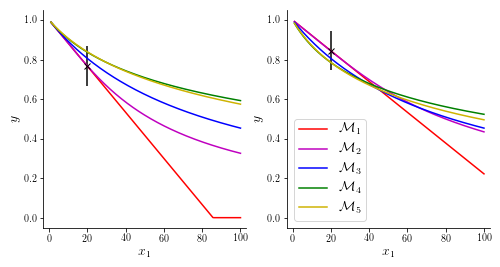

In [9]:
graphics.plot_fitted_models(Ms)

<h1>Train surrogate models</h1>

We will now generate training data for the surrogate models, and learn the GP hyperparameters.

<h4>Training data</h4>

We generate a mesh $\texttt{Xsim}$ of design variable values. Then we randomly sample model parameter values $\texttt{Psim}$ in a small region around the best-fit model parameter value $\texttt{pmean}$ for each model. These design variable and model parameter values are used as inputs for model evaluations $\texttt{Ysim}$.

In [10]:
def generate_x_mesh ():
    X = np.meshgrid( np.linspace(*x_bounds[0], num=20),   # x_1
                     np.linspace(*x_bounds[1], num=20),   # x_2
                     [0, 1])                              # x_3
    return np.vstack( map(np.ravel, X) ).T
    
def generate_p_values (pmean, N):
    return np.random.uniform(0.995*pmean, 1.005*pmean, size=[N, 1]) # pmean +- 0.5%

def training_data (model):
    Xsim = generate_x_mesh()
    Xsim = np.vstack( (Xsim, Xsim) )
    Psim = generate_p_values( M.pmean, len(Xsim) )
    Zsim = np.c_[Xsim, Psim]
    Ysim = np.array([M.call(x, p) for x, p in zip(Xsim, Psim)])
    model.set_training_data(Zsim, Ysim)
    
for M in Ms:
    training_data(M)

<h4>Choosing covariance functions</h4>

We decide to use a Matern-5/2 covariance function for the design variable dimensions, and an RBF covariance function for the model parameter dimension.

In [11]:
from GPdoemd.kernels import RBF, Matern52

for M in Ms:
    M.kern_x = Matern52  # Design variable covariance function
    M.kern_p = RBF       # Model parameter covariance function

<h4>Learn GP hyperparameters</h4>

We learn the GP hyperparameters through evidence maximisation.

In [12]:
for M in Ms:
    M.gp_surrogate()
    M.gp_optimise()
    print('Trained: ' + M.name)

Trained: M1
Trained: M2
Trained: M3
Trained: M4
Trained: M5


Plot GP predictions. This is done by calling $\texttt{M}.\texttt{predict}(\texttt{x})$ for test points $\texttt{x}$. (Compare to plots of fitted original models.)

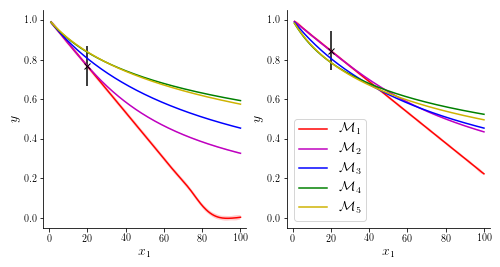

In [13]:
graphics.gp_plot(Ms)

<h1>Marginal predictive distributions</h1>

We now use a first-order Taylor approximation to (i) compute the covariance of each model's parameter distribution, and (ii) compute the marginal predictive distributions of each model.

In [14]:
from GPdoemd.marginal import TaylorFirstOrder

# (i)
for M in Ms:
    M.marginal_init(TaylorFirstOrder) # Initialise
    M.marginal_compute_covar(X)       # Compute model parameter covariance

Plot marginal predictive distributions. The marginal predictive distributions are computed by calling $\texttt{M}.\texttt{marginal}\_\texttt{predict}(\texttt{x})$ for test points $\texttt{x}$.

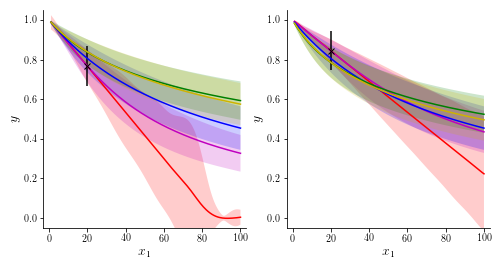

In [15]:
# (ii)
graphics.marginal_plot(Ms)

<h1>Model posteriors</h1>

Now we want to compute the probability for each model to be the data-generating model. 

In [16]:
from GPdoemd.discrimination_criteria import aicw

mu = np.zeros((len(X), len(Ms), 1))     # Means
s2 = np.zeros((len(X), len(Ms), 1, 1))  # Covariances
D  = np.array([1] * len(Ms))            # Number of model parameters for each model

for i, M in enumerate(Ms):
    mu[:,i], s2[:,i] = M.marginal_predict( X )

pis = aicw(Y, mu, s2, D)
for M, p in zip(Ms, pis):
    print(M.name + ': {:.5f}'.format(p))

M1: 0.47455
M2: 0.48895
M3: 0.03600
M4: 0.00031
M5: 0.00020


We see that models 1 and 2 are deemed the most probable data-generators. However, the difference in probability is relatively small. Often we require many (e.g. 8) orders of magnitudes' difference before we discard any models.

<h1>Design the next experiment</h1>

Because no model is significantly more probably than all others, we design an additional experiment.

In [17]:
from GPdoemd.design_criteria import HR, BH, BF, AW, JR

Xtest = generate_x_mesh()                   # Test points
mu = np.zeros((len(Xtest), len(Ms), 1))     # Means
s2 = np.zeros((len(Xtest), len(Ms), 1, 1))  # Covariances

# Marginal predictive distributions
for i, M in enumerate(Ms):
    mu[:,i], s2[:,i] = M.marginal_predict( Xtest )

Xnext = []
print('Recommended experiments:')
print('{:4}{:>7}{:>7}{:>7}'.format('','x_1','x_2','x_3'))
for DC in ['HR', 'BH', 'BF', 'AW', 'JR']:
    dc = eval(DC + '(mu, s2, measvar, pis)')  # Call design criterion
    i  = np.argmax(dc)                        # Find index of optimal next experiment
    xn = Xtest[i]                             # Optimal next experiment
    Xnext.append(xn)
    print('{:4}{:7.2f}{:7.2f}{:7.0f}'.format(DC+':', *xn))

Recommended experiments:
        x_1    x_2    x_3
HR:    6.21   0.01      1
BH:    6.21   0.01      0
BF:    6.21   0.01      1
AW:   32.26   0.17      0
JR:   37.47   0.22      0


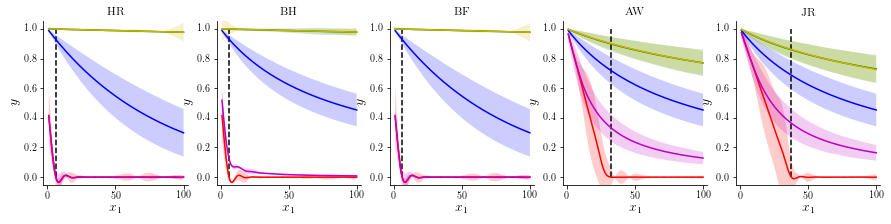

In [18]:
graphics.design_plot(Ms, ['HR', 'BH', 'BF', 'AW', 'JR'], Xnext)

<h4>Next experiment</h4>

We run the experiment suggested by JR design criterion and add the observation to our data set.

In [19]:
xnext = Xnext[-1]
ynext = measurement(xnext)

X = np.vstack(( X, xnext ))
Y = np.vstack(( Y, ynext ))

graphics = Graphics(X, Y, measvar)

<h1>Update surrogate models</h1>

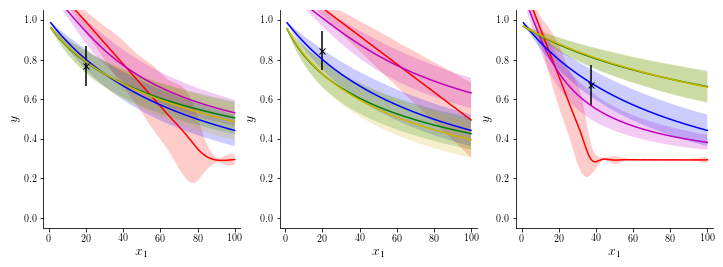

In [20]:
for M in Ms:
    # Parameter estimation
    M.param_estim(X, Y, diff_evol, M.p_bounds)
    
    # Training data
    training_data(M)
    # Learn GP hyperparameters
    M.gp_optimise()
    
    # Compute model parameter covariance
    M.marginal_compute_covar(X)
    
graphics.marginal_plot(Ms)

<h1>Updated model posteriors</h1>

In [21]:
mu = np.zeros((len(X), len(Ms), 1))     # Means
s2 = np.zeros((len(X), len(Ms), 1, 1))  # Covariances
D  = np.array([1] * len(Ms))            # Number of model parameters for each model

for i, M in enumerate(Ms):
    mu[:,i], s2[:,i] = M.marginal_predict( X )

pis = aicw(Y, mu, s2, D)
for M, p in zip(Ms, pis):
    print(M.name + ': {:.5f}'.format(p))

M1: 0.00000
M2: 0.00000
M3: 1.00000
M4: 0.00000
M5: 0.00000


We see that the true data-generating model ($\mathcal{M}_3$) now has a much higher posterior than the other models.